## Formula 1
Business Problem: What factors/features are needed to predict race outcome

1. Import required libraries

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from statsmodels.formula.api import ols
from scipy.stats import norm, probplot
from sklearn.preprocessing import StandardScaler


Get Data from the erghast F1 API
</br> Contains data from all the races since 1950

2. Import the datasets from the erghast API for the prediction

In [165]:
db_dir = os.getcwd()
pit_stops = pd.read_csv(db_dir + r'/data/pit_stops.csv')
races = pd.read_csv(db_dir + r'/data/races.csv')
drivers = pd.read_csv(db_dir + r'/data/drivers.csv')
results = pd.read_csv(db_dir + r'/data/results.csv')
driver_standings = pd.read_csv(db_dir + r'/data/driver_standings.csv')
circuits = pd.read_csv(db_dir + r'/data/circuits.csv')
qualifying = pd.read_csv(db_dir + r'/data/qualifying.csv')
lap_times = pd.read_csv(db_dir + r'/data/lap_times.csv')
lap_times = lap_times.rename(columns={
    'time': 'lapTime',
    'position': 'lapPosition'})

merged_df = pd.merge(races, pit_stops, on='raceId', how='inner')
df = pd.merge(merged_df, drivers, on='driverId', how='inner')
df = df.drop(columns=['url_x','url_y','number'])

# distinct_raceyear_df = df.drop_duplicates(subset='year').sort_values(by='year', ascending=False)
df_new_merged = pd.merge(df, results, on=['driverId','raceId'], how='inner')
df_new_merged1 = pd.merge(df_new_merged, driver_standings, on=['driverId','raceId'], how='inner')
df_new_merged = pd.merge(df_new_merged, circuits, on=['circuitId'], how='inner')
# df_new_merged = pd.merge(df_new_merged, qualifying, on=['driverId','raceId'], how='inner')
# df_new_merged = pd.merge(df_new_merged, lap_times, on=['driverId','raceId'], how='inner')

condition1 = df_new_merged['year'] >= 2000
condition2 = df_new_merged['year'] <= 2023
df_new_merged1 = df_new_merged[condition1 & condition2 ] 
print(df_new_merged1.columns)
df_new_merged1.to_csv('all.csv')
def convert_new_time_to_seconds_v4(time_str):
    if time_str == '\\N':
        return np.nan
    try:
        # Split by colon and reverse the list to start with seconds and go backwards to minutes, hours, etc.
        time_parts = list(map(float, time_str.split(':')))[::-1]
        # Convert parts to seconds: seconds, minutes to seconds, hours to seconds
        total_seconds = sum(time_part * (60 ** index) for index, time_part in enumerate(time_parts))
        return total_seconds
    except ValueError:
        return np.nan

# Apply the function to the 'new_time' column
df_new_merged1['new_time_seconds'] = df_new_merged1['time'].replace('\+', '', regex=True).apply(convert_new_time_to_seconds_v4)
# df_new_merged1[df_new_merged1['raceId']== 948].sort_values(by=['raceId', 'positionOrder'])
df_cleaned = df_new_merged1[['raceId','year','round','circuitRef','circuit_type','circuit_type_num','driverId','grid','rank','position','positionOrder','time','new_time_seconds','stop']]
df_cleaned = df_cleaned.drop_duplicates()
# df_cleaned['cumulative_time_seconds'] = df_cleaned.groupby(['raceId', 'positionOrder'])['new_time_seconds'].transform(lambda x: x.cumsum())
df_cleaned.sort_values(by=['raceId', 'positionOrder'], inplace=True)
df_cleaned['cumulative_time_seconds'] = df_cleaned.groupby('raceId')['new_time_seconds'].cumsum()
df_cleaned = df_cleaned[['raceId','year','circuitRef','circuit_type','circuit_type_num','driverId','grid','cumulative_time_seconds','rank','stop']]

df_cleaned[df_cleaned['raceId']== 950].sort_values(by=['raceId','grid'])

# df_cleaned = df_cleaned[df_cleaned['circuitRef']== 'monaco']
df_cleaned = df_cleaned[df_cleaned['circuit_type_num']== 2]
#Drop retired racers
df_cleaned = df_cleaned.dropna()
df_cleaned.to_csv('clean.csv')

Index(['raceId', 'year', 'round', 'circuitId', 'name_x', 'date', 'time_x',
       'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'driverId',
       'stop', 'lap', 'time_y', 'duration', 'milliseconds_x', 'driverRef',
       'code', 'forename', 'surname', 'dob', 'nationality', 'resultId',
       'constructorId', 'number', 'grid', 'position', 'positionText',
       'positionOrder', 'points', 'laps', 'time', 'milliseconds_y',
       'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId',
       'circuitRef', 'name_y', 'location', 'country', 'lat', 'lng', 'alt',
       'url', 'circuit_type', 'circuit_type_num'],
      dtype='object')


/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_53368/2778849473.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_merged1['new_time_seconds'] = df_new_merged1['time'].replace('\+', '', regex=True).apply(convert_new_time_to_seconds_v4)


R-Squared: 0.2826001821175733
                               OLS Regression Results                              
Dep. Variable:     cumulative_time_seconds   R-squared:                       0.236
Model:                                 OLS   Adj. R-squared:                  0.235
Method:                      Least Squares   F-statistic:                     182.3
Date:                     Mon, 22 Jul 2024   Prob (F-statistic):          5.26e-103
Time:                             22:00:59   Log-Likelihood:                -17894.
No. Observations:                     1774   AIC:                         3.580e+04
Df Residuals:                         1770   BIC:                         3.582e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

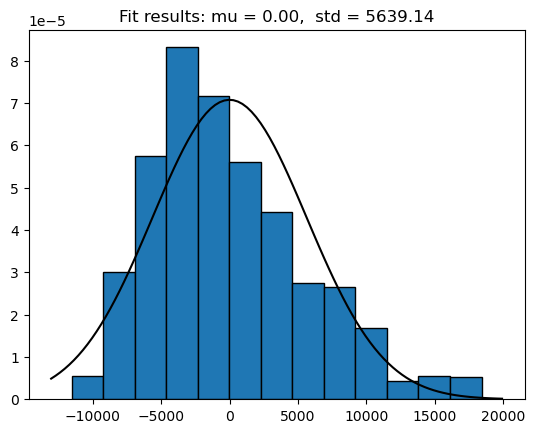

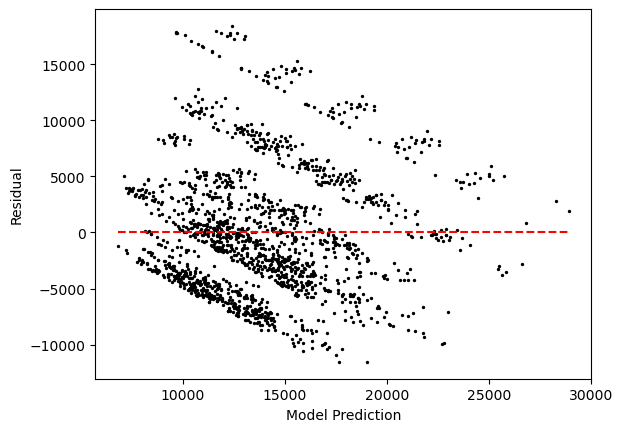

{'LM Statistic': 128.75558893775369, 'LM-Test p-value': 7.186366638817257e-27, 'F-Statistic': 46.17295580066889, 'F-Test p-value': 9.990589730069863e-29}


In [166]:
X = df_cleaned[['raceId','year','driverId','grid','circuit_type_num','rank','stop']].values
y = df_cleaned['cumulative_time_seconds'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.95,random_state=0)

'''
Fitting data to a regression model requires two arguments, the training X
values (independent variables) and the training y values (dependent variables.
In general, most fit functions for models follow this format.
'''
reg = LinearRegression().fit(X_train, y_train)
print("R-Squared:", reg.score(X_train, y_train))

from statsmodels.formula.api import ols

model = ols('cumulative_time_seconds ~ grid+circuit_type_num+year+stop',df_cleaned).fit()
print(model.summary())

#Test for normality
predicted_y = reg.predict(X_train)
residuals = y_train - predicted_y

from scipy.stats import norm
mean, std = norm.fit(residuals)
plt.hist(residuals, bins=13, edgecolor='black', density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, color='black')
title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)
plt.show()

#Test for heteroskacticity
#Residuals calculated by definition above.
predicted_y = reg.predict(X_train)
#Note we can perform element-wise subtraction between arrays like so
residuals = y_train - predicted_y
import matplotlib.pyplot as plt
plt.scatter(predicted_y,residuals,s=2,c='black')
plt.hlines(0,min(predicted_y),max(predicted_y),color='red',linestyles='dashed')
plt.xlabel("Model Prediction")
plt.ylabel("Residual")
plt.show()

#Perform the Breuch-Pagan Test by running this line
from statsmodels.stats.diagnostic import het_breuschpagan
bp = het_breuschpagan(model.resid,model.model.exog)
measures = ('LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value')
print(dict(zip(measures,bp)))

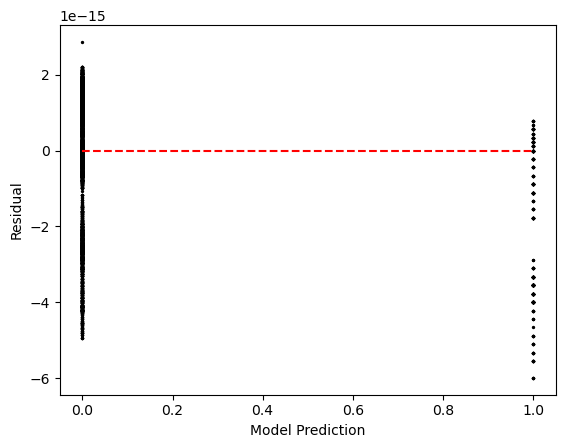

In [9]:
#Residuals calculated by definition above.
predicted_y = reg.predict(X_train)
#Note we can perform element-wise subtraction between arrays like so
residuals = y_train - predicted_y

import matplotlib.pyplot as plt
plt.scatter(predicted_y,residuals,s=2,c='black')

#This line adds the dashed horizontal line
plt.hlines(0,min(predicted_y),max(predicted_y),color='red',linestyles='dashed')

plt.xlabel("Model Prediction")
plt.ylabel("Residual")
plt.show()

Old Results

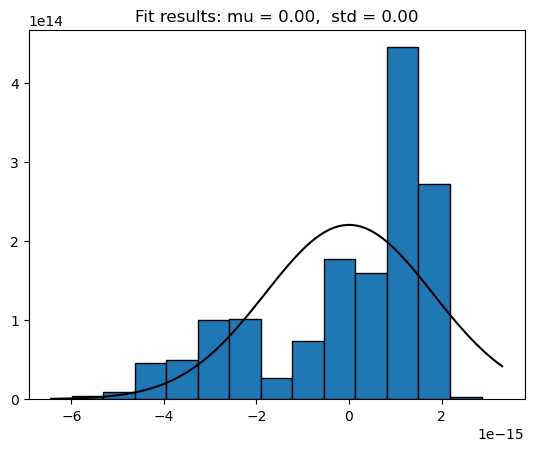

In [10]:
from scipy.stats import norm

# Fit a normal distribution to the data:
mean, std = norm.fit(residuals)

# Plot the histogram.
plt.hist(residuals, bins=13, edgecolor='black', density=True)

# Generate a PDF based on the fitted distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, color='black')
title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulating some left-skewed data
data = np.random.exponential(scale=1, size=1000) - 1.5

# Step 1: Adjust data if there are negative or zero values
data_min = data.min()
if data_min <= 0:
    data_adjusted = data + (abs(data_min) + 1)
else:
    data_adjusted = data

# Step 2: Apply log transformation
data_log_transformed = np.log(data_adjusted)

# Step 3: Plotting the transformed data
plt.figure(figsize=(10, 6))
plt.hist(data_log_transformed, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Log Transformed Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Pagan Test to further test the heteroskacticity

In [26]:
#Import the relevant libraries and train the model
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan

results = ols('RaceWinner ~ raceId+year+round+circuitId+driverId+grid+positionOrder+fastestLapTime_seconds+points+rank+laps',df_cleaned).fit()
#Perform the Breuch-Pagan Test by running this line
bp = het_breuschpagan(results.resid,results.model.exog)
measures = ('LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value')
print(dict(zip(measures,bp)))

{'LM Statistic': 4506.929957615278, 'LM-Test p-value': 0.0, 'F-Statistic': 569.1796155612536, 'F-Test p-value': 0.0}


In [27]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Predictions on the test set
y_pred_test = reg.predict(X_test)

# Evaluating the model on the test data
r_squared_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print("R-Squared on Test Data:", r_squared_test)
print("Mean Squared Error on Test Data:", mse_test)

R-Squared on Test Data: 1.0
Mean Squared Error on Test Data: 3.7079585429789036e-30


In [44]:
condition11 = df_new_merged['year'] == 2024 
condition12 = df_new_merged['round']  == 10
to_predict = df_new_merged[condition11 & condition12]
relevant_columns = ['raceId', 'year', 'round', 'circuitId', 'driverId', 'grid', 'positionOrder', 'points','rank','laps','fastestLapTime']
# relevant_columns = ['raceId', 'grid', 'positionOrder', 'fastestLapTime', 'points','RaceWinner']
to_predict = to_predict[relevant_columns]
to_predict['fastestLapTime_seconds'] = to_predict['fastestLapTime'].apply(time_to_seconds)
to_predict = to_predict.drop(columns=['fastestLapTime'])
to_predict.to_csv('to_predict.csv')

In [45]:
# Add a constant for prediction with statsmodels
features_sm = sm.add_constant(to_predict)

# Prediction using the built model
predict_final_race_outcome = results.predict(features_sm)
predict_final_race_outcome.to_csv('predict.csv')